# Add Folders to Path

We start by adding the necessary folders to the current working path.

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add Hamiltonian folder to current working path
sys.path.append(parent_directory+"/demos/ActiveBarriers/Hamiltonian")

Wall time: 0 ns


# Overview
We illustrate the extraction of active barriers to the transport of momentum and vorticity as level sets of the Hamiltonian on 2-D homogeneous, isotropic turbulence. In 2D incompressible flows the Lagrangian (and also instantaneous) active barrier equations are Hamiltonians. Convex level sets surrounding local extrema of the appropriate Hamiltonian block the transport of linear momentum and vorticity. In order to extract closed convex level sets of the Hamiltonian we emply the contour-finding algorithm used in the [LAVD](http://localhost:8888/notebooks/TBarrier/2D/demos/AdvectiveBarriers/LAVD/find_outermost_contour.ipynb)-computation. The notebook is structured as follows:

1. Import vorticity and velocity data stored in the folder 'data/Turbulence'. Make sure that all the necessary files are stored in the folder 'data/Turbulence'.
<br />
2. Define computational parameters (such as the number of cores) and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data.
 <br />
5. Compute particle trajectories.
 <br />
6. Compute Hamiltonian of Lagrangian linear momentum barrier equation:

   <br />
   
   * For 2D incompressible, uniform-density Navier–Stokes flows, the Lagrangian barrier equation for linear momentum is an autonomous Hamiltonian system of the form:
    
     \begin{equation}
     \mathbf{x}_0'=\nu \rho \mathbf{J} \mathbf{\nabla_0 \overline{\omega (\mathbf{F_{t_0}^{t}(\mathbf{x}_0)}, t)}},
     \label{eq: linearmomentum} 
     \end{equation}
    
    Time 't' is just a fixed parameter and hence the system is autonomous and the integration is done with respect to a dummy time variable 's'. 's' can be arbitrarily large.
    
    The Hamiltonian $ \mathrm{H_m}_{t_0}^{t_N}(\mathbf{x}_0) $ is given by:
    
    \begin{equation}
    \mathrm{H_m}_{t_0}^{t_N}(\mathbf{x}_0) = \nu \rho \overline{\omega (\mathbf{F_{t_0}^t}(\mathbf{x}_0, t)}, \quad t \in [t_0, t_N]
    \label{eq: HamiltonianLinearMomentum}
    \end{equation}
    
    <br />
    
   * We start by evaluating the right-hand-side of equation \ref{eq: HamiltonianLinearMomentum} by interpolating $ \overline{\omega (\mathbf{F_{t_0}^t}(\mathbf{x}_0, t)} $ over the spatial meshgrid.
   
   <br />
   
   * We then find almost convex structurally stable level sets of $ \mathrm{H_m}_{t_0}^{t_N}(\mathbf{x}_0) $
   
   <br />
   
7. Compute Hamiltonian of Lagrangian vorticity barrier equation:

   <br />
   
   * For 2D incompressible, uniform-density Navier–Stokes flows, the Lagrangian barrier equation for linear momentum is an autonomous Hamiltonian system of the form:
   
       \begin{equation}
       \mathbf{x}_0' = \dfrac{\nu}{t_N-t_0} \mathbf{J} \nabla_0 \delta \mathbf{\omega (\mathbf{x}_0, t_0,t_N)}
       \label{eq: vorticity},
       \end{equation}
   
        where $ \nu $ is the viscosity, $ \mathbf{J} = \begin{pmatrix} 0 && 1 \\ -1 && 0 \end{pmatrix} $ and $ \delta \mathbf{\omega (\mathbf{x}_0, t_0,t_N)} = \mathbf{\omega} (\mathbf{F}_{t_0}^{t_N}(\mathbf{x}_0), t_N) - \mathbf{\omega}(\mathbf{x}_0, t_0) $.
    
    Time 't' is just a fixed parameter and hence the system is autonomous and the integration is done with respect to a dummy time variable 's'. 's' can be arbitrarily large.
    
    The Hamiltonian $ \mathrm{H_v}_{t_0}^{t_N}(\mathbf{x}_0) $ of equation \ref{eq: vorticity} is given by:
    
    \begin{equation}
    \mathrm{H_v}_{t_0}^{t_N}(\mathbf{x}_0) = \dfrac{\nu}{t_N-t_0} \delta \mathbf{\omega (\mathbf{x}_0, t_0,t_N)},
    \label{eq: HamiltonianVorticity}
    \end{equation}
    
    <br />
    
   * We start by evaluating the right-hand-side of equation \ref{eq: HamiltonianVorticity} by interpolating $ \delta \mathbf{\omega (\mathbf{x}_0, t_0,t_N)} $ over the spatial meshgrid.
   
   <br />
   
   * We then find almost convex structurally stable level sets of $ \mathrm{H_v}_{t_0}^{t_N}(\mathbf{x}_0) $

# Import Data

In [2]:
%%time
# import scipy
import scipy.io

# import numpy
import numpy as np

# load vorticity data
turb_w = parent_directory + r'/data/Turbulence/turb_w'

omega = np.zeros((1024, 1024, 251))

# iterate over all files in folder 'turb_w' and load vorticity data
i = 0
for filename in sorted(os.listdir(turb_w)):
    if filename.endswith(".mat"):
        file_w = os.path.join(turb_w, filename)
        mat_turb_w = scipy.io.loadmat(file_w)
        omega[:,:,i] = mat_turb_w['w']
        i+=1

# load velocity data
turb_u = parent_directory + r'/data/Turbulence/turb_u'
      
# iterate over all files in folder 'turb_u' and load velocity data
i = 0
U = np.zeros((1024, 1024, 251))
V = np.zeros((1024, 1024, 251))
for filename in sorted(os.listdir(turb_u)):
    if filename.endswith(".mat"):
        file_u = os.path.join(turb_u, filename)
        mat_turb_u = scipy.io.loadmat(file_u)
        U[:,:,i] = mat_turb_u['u1']
        V[:,:,i] = mat_turb_u['u2']
        i+=1

# load x/y grid
X = scipy.io.loadmat(parent_directory + r'/data/Turbulence/grid.mat')['x']
Y = X.copy().transpose()

Wall time: 33.9 s


# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# Number of cores for parallel computing
Ncores = 4

# time-interval over which data is defined
time_data = np.linspace(0, 25, 251, endpoint = True).reshape(1, -1)

# time resolution of data
dt_data = time_data[0,1]-time_data[0,0]

# periodic boundary conditions
periodic_x = True
periodic_y = True
periodic_t = False
periodic = [periodic_x, periodic_y, periodic_t]

# unsteady velocity field
bool_unsteady = True

# defined domain
# This array denotes where the velocity field is defined (=1) and where it is not defined (=0)
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
%%time
# Initial time
t0 = 0 # int

# Final time
tN = 25 # int

# time step-size
dt = .2 # float

# Time array
time = np.arange(t0, tN+dt, dt) # array (Nt, )

# length of time interval (in days)
lenT = tN-t0

# domain boundary (in degrees)
xmin = 3 # float [0, 2pi]
xmax = 5 # float [0, 2pi]
ymin = 1 # float [0, 2pi]
ymax = 3 # float [0, 2pi]

# make sure that the spatio-temporal you defined are within the domain of the data
assert (xmax <= np.max(X) and xmin >= np.min(X) and ymin >= np.min(Y) and ymax <= np.max(Y) and t0 >= np.min(time_data) and tN <= np.max(time_data)),"The domains you are chooising are outside the domain of the data!!!!! --> redefine spatial/temporal domain"

# spacing of meshgrid (in degrees)
dx = 0.01 # float
dy = 0.01 # float

# NOTE: As we are computing spatial derivatives of the CG-tensor, the spacing of the meshgrid has to be sufficiently small.
# However, choosing dx to be too small leads to (unnecessary) long computation times.

x_domain = np.arange(xmin, xmax + dx, dx) # array (Nx,)
y_domain = np.arange(ymin, ymax + dy, dy) # array (Ny,)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

Ny = Y_domain.shape[0]
Nx = X_domain.shape[1]

Wall time: 2.01 ms


# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". Default value is "cubic".

In [5]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# set nan values to zero so that we can apply interpolant. Interpolant does not work if the array contains nan values
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic")

Interpolant_u = Interpolant[0] # RectangularBivariateSpline object
Interpolant_v = Interpolant[1] # RectangularBivariateSpline object

Wall time: 36.9 s


# Compute trajectories

In [6]:
%%time
# Import function to compute gradient of flow map
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import function to compute trajectories (=flow map)
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import package for parallel computing
from joblib import Parallel, delayed

# vectorize initial conditions
x0 = X_domain.ravel() # array (Nx*Ny, )
y0 = Y_domain.ravel() # array (Nx*Ny, )

# split x0, y0 into 'Ncores' (equal) batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

x0_batch = list(split(x0, Ncores)) # list (Nx*Ny,)
y0_batch = list(split(y0, Ncores)) # list (Nx*Ny,)

def parallel_Fmap(x0_batch, y0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch]) # array (2, Nx*Ny)
    
    Fmap = integration_dFdt(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, bool_unsteady, time_data)[0] # array (Nt, 2, Nx*Ny)
    
    return Fmap

results = Parallel(n_jobs=Ncores, verbose = 50)(delayed(parallel_Fmap)(x0_batch[i], y0_batch[i]) for i in range(len(x0_batch)))

# extract trajectories from results of parallel computing
Fmap = results[0]

for res in results[1:]:
    Fmap = np.append(Fmap, res, axis = 2)
    
# reshape array from vectorized form to structured meshgrid
X0_gridded = x0.reshape((X_domain.shape[0], X_domain.shape[1])) # array (Ny, Nx)
Y0_gridded = y0.reshape((X_domain.shape[0], X_domain.shape[1])) # array (Ny, Nx)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   17.3s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   18.2s remaining:   18.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   19.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   19.9s finished
Wall time: 21.3 s


# Lagrangian linear momentum barriers

We visualize active barriers to linear momentum by plotting the level sets of the Hamiltonian for the Lagrangian linear momentum barrier equations \ref{eq: HamiltonianLinearMomentum}.

## Interpolate Hamiltonian

We start by computing the interpolant for the instantaneous momentum barrier field. The interpolant is given by the right-hand-side of equation \ref{eq: HamiltonianLinearMomentum}.

In [7]:
%%time
# Import function to interpolate the Hamiltonian for Lagrangian active momentum barrier equation
from ipynb.fs.defs.HamiltonianLagrangianActiveMomentum import HamiltonianLagrangianActiveMomentum

# Interpolate Hamiltonian of linear momentum barrier equation using cubic spatial interpolation
Interpolant_Hamiltonian_momentum = HamiltonianLagrangianActiveMomentum(X_domain, Y_domain, X, Y, omega, Fmap, time, dt_data)

  0%|          | 0/251 [00:00<?, ?it/s]

Wall time: 23.2 s


## Compute level sets of Hamiltonian

Next, we compute the outermost (almost) convex level sets surrounding a local maximum of the Hamiltonian defined in equation \ref{eq: HamiltonianLinearMomentum}.

In [8]:
from ipynb.fs.defs.find_outermost_contour import find_outermost_contour

# Compute Hamiltonian over meshgrid
H_Lagrangian_momentum = np.abs(Interpolant_Hamiltonian_momentum(Y_domain.ravel(), X_domain.ravel(), grid = False).reshape(Ny, Nx))

# Minimum distance between local maxima in the H_LagrangianMomentum field
distance = 0.5 # float >=0

# Resolution of H_LagrangianMomentum field when extracting contours
n = 250 # int

# Convexity deficiency
c_d = 10**(-2) # float > 0

# Reject local maxima below this threshold
loc_threshold = 0.2 # float >= 0

# Minimum length of outermost (almost) convex level sets
l_min = 0.4 # float >= 0

# Compute outermost (almost) convex level sets
level_sets_Hamiltonian_momentum = find_outermost_contour(X_domain, Y_domain, H_Lagrangian_momentum, distance, n, c_d, l_min, loc_threshold, Ncores)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done   2 out of   7 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=4)]: Done   3 out of   7 | elapsed:    1.3s remaining:    1.8s
[Parallel(n_jobs=4)]: Done   4 out of   7 | elapsed:    1.5s remaining:    1.1s
[Parallel(n_jobs=4)]: Done   5 out of   7 | elapsed:    1.8s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   7 out of   7 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   7 out of   7 | elapsed:    3.2s finished


# Lagrangian vorticity barriers

We visualize active barriers to linear momentum by plotting the level sets of the Hamiltonian for the Lagrangian vorticity barrier equations \ref{eq: HamiltonianVorticity}.

## Interpolate Hamiltonian

We start by computing the interpolant of the Hamiltonian for the Lagrangian vorticity barrier field. The interpolant is given by the right-hand-side of equation \ref{eq: HamiltonianVorticity}.

In [9]:
%%time
# Import function to interpolate the Hamiltonian for Lagrangian vorticity barrier equation
from ipynb.fs.defs.HamiltonianLagrangianActiveVorticity import HamiltonianLagrangianActiveVorticity

# Interpolate Lagrangian vorticity barrier equation using cubic spatial interpolation
Interpolant_Hamiltonian_vorticity = HamiltonianLagrangianActiveVorticity(X_domain, Y_domain, X, Y, omega, Fmap, time, dt_data)

Wall time: 191 ms


## Compute level sets of Hamiltonian

Next, we compute the outermost (almost) convex level sets surrounding a local maximum of the Hamiltonian defined in equation \ref{eq: HamiltonianVorticity}.

In [10]:
# Compute Hamiltonian over meshgrid
H_Lagrangian_vorticity = np.abs(Interpolant_Hamiltonian_vorticity(Y_domain.ravel(), X_domain.ravel(), grid = False).reshape(Ny, Nx))

# Minimum distance between local maxima in the H_LagrangianMomentum field
distance = 0.5 # float >=0

# Resolution of H_LagrangianMomentum field when extracting contours
n = 250 # int

# Convexity deficiency
c_d = 10**(-2) # float > 0

# Reject local maxima below this threshold
loc_threshold = 0.2 # float >= 0

# Minimum length of outermost (almost) convex level sets
l_min = 0.4 # float >= 0

# Compute outermost (almost) convex level sets
level_sets_Hamiltonian_vorticity = find_outermost_contour(X_domain, Y_domain, H_Lagrangian_vorticity, distance, n, c_d, l_min, loc_threshold, Ncores)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done   2 out of   7 | elapsed:    1.9s remaining:    4.9s
[Parallel(n_jobs=4)]: Done   3 out of   7 | elapsed:    2.0s remaining:    2.7s
[Parallel(n_jobs=4)]: Done   4 out of   7 | elapsed:    2.0s remaining:    1.5s
[Parallel(n_jobs=4)]: Done   5 out of   7 | elapsed:    3.8s remaining:    1.5s
[Parallel(n_jobs=4)]: Done   7 out of   7 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   7 out of   7 | elapsed:    4.7s finished


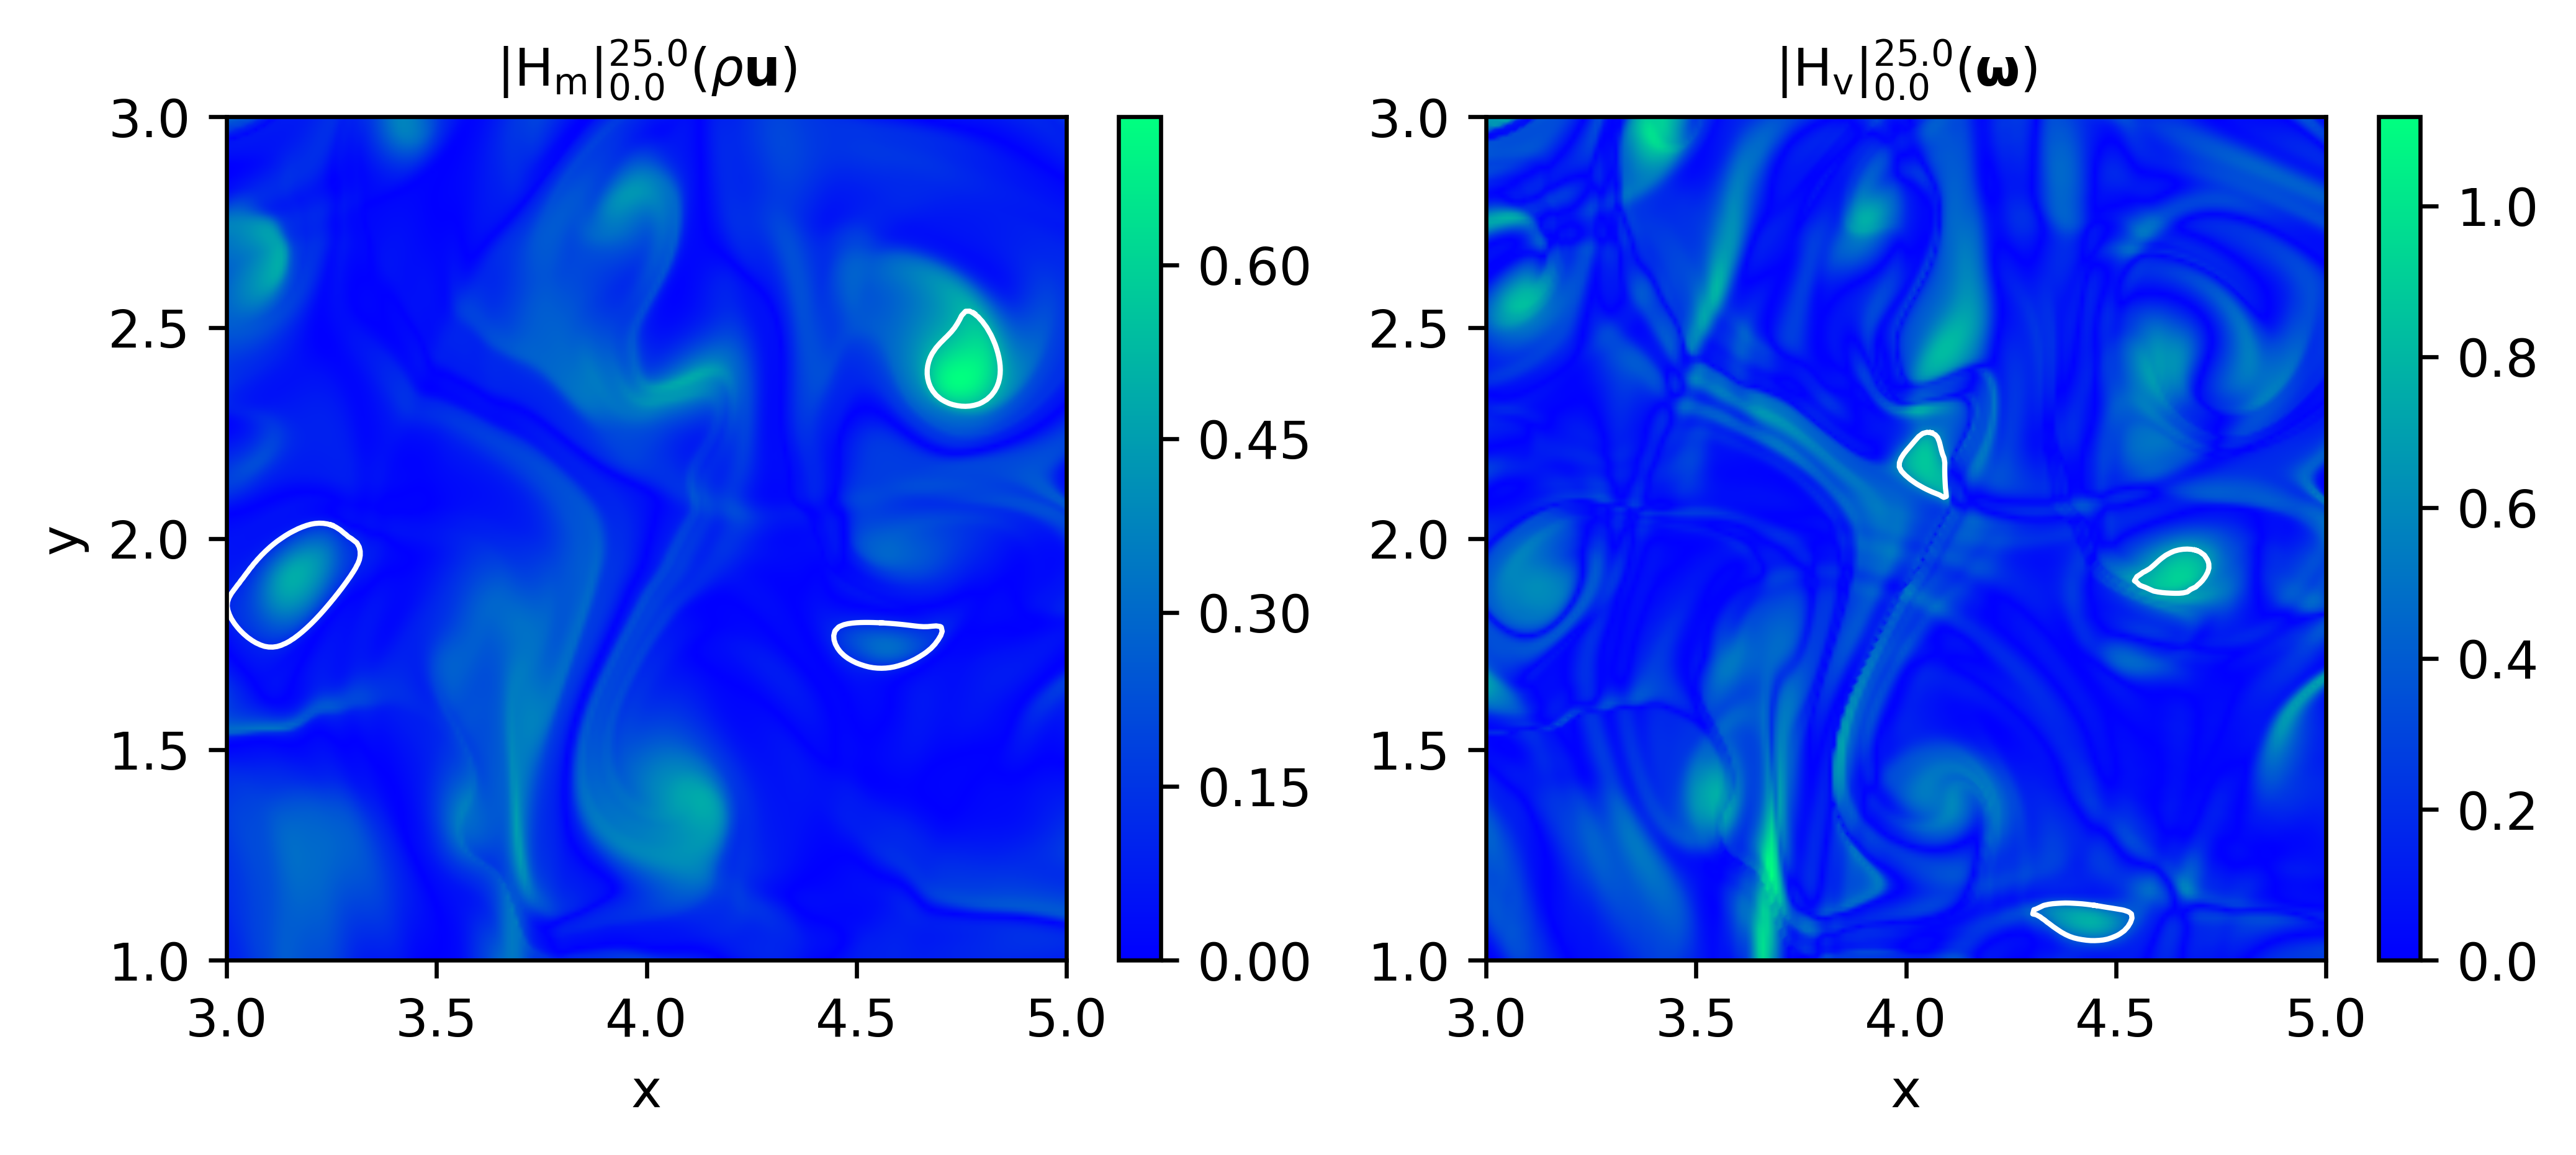

In [11]:
################################################ PLOT RESULTS ################################################

# Import plotting library
import matplotlib.pyplot as plt

# Figure/Axis
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, dpi = 600, figsize=(8, 3))

# Contourplot of Hamiltonian for Lagrangian linear momentum
cax = ax0.contourf(X_domain, Y_domain, H_Lagrangian_momentum, cmap = "winter", levels = 600)
# level sets of Hamiltonian for Lagrangian linear momentum
for v in level_sets_Hamiltonian_momentum:
    ax0.plot(v[0], v[1], linewidth = 1, c = "w")
# Colorbar
cbar = fig.colorbar(cax, ax = ax0, ticks = np.arange(0, 1, .15))

# Contourplot of Hamiltonian for Lagrangian vorticity
cax = ax1.contourf(X_domain, Y_domain, H_Lagrangian_vorticity, cmap = "winter", levels = 600)
# level sets of Hamiltonian for Lagrangian vorticity
for v in level_sets_Hamiltonian_vorticity:
    ax1.plot(v[0], v[1], linewidth = 1, c = "w")
# Colorbar
cbar = fig.colorbar(cax, ax = ax1, ticks = np.arange(0, 1.2, .2))

# Axis Labels
ax0.set_ylabel("y", fontsize = 10)
ax0.set_xlabel("x", fontsize = 10)
ax1.set_xlabel("x", fontsize = 10)

ax0.set_title(r'$\mathrm{|H_m|}$'+f'$_{{{np.around(time[0], 1)}}}^{{{np.around(time[-1], 1)}}}$'+r'($\rho \mathbf{u}$)', fontsize = 10)
ax1.set_title(r'$\mathrm{|H_v|}$'+f'$_{{{np.around(time[0], 1)}}}^{{{np.around(time[-1], 1)}}}$'+r'($ \mathbf{\omega}$)', fontsize = 10)
              
plt.show()

The figures focus on momentum and vorticity-based active barriers of the two-dimensional turbulence model.
Almost convex level sets surrounding local maxima of the appropriate Hamiltonian respectively inhibit the transport of linear momentum and vorticity.
Compared to the active coherent structure diagnostics (aFTLE, aPRA, aTSE, aTRA), the structures of the Hamiltonian do not depend on the parameter 's' (=dummy time).

Finally, we point out that level sets of the Hamiltonian of the Eulerian (=instantaneous) linear momentum and vorticity barrier equations lead to similar conclusions.

# References

[1] Haller, G., Katsanoulis, S., Holzner, M., Frohnapfel, B., & Gatti, D. (2020). Objective barriers to the transport of dynamically active vector fields. Journal of Fluid Mechanics, 905.